# 🧪 Classic Super-Resolution Techniques
This notebook presents practical implementations of five classical super-resolution techniques:
1. Bilinear, Bicubic, Area and Lanczos interpolation
2. Iterative Back-Projection (IBP)
3. Non-Local Means Super-Resolution
4. Edge-Guided Interpolation (EGI)
5. Frequency Domain Extrapolation

In [1]:
import os
import sys
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

from SRModels.classic_super_resolution_algorithms.profiling_methods import *
from SRModels.classic_super_resolution_algorithms.classic_algorithms import *
from SRModels.classic_super_resolution_algorithms.visualization_methods import *

## Tracking structures for profiling data

In [2]:
algorithms = ['bilinear','bicubic','area','lanczos','ibp','nlm','egi','freq']

time_stats = {
    'bilinear': [], 'bicubic': [], 'area': [], 'lanczos': [],
    'ibp': [], 'nlm': [], 'egi': [], 'freq': []
}
memory_stats = {k: [] for k in time_stats}
psnr_stats = {k: [] for k in time_stats}
ssim_stats = {k: [] for k in time_stats}
mae_stats = {k: [] for k in time_stats}
rmse_stats = {k: [] for k in time_stats}
throughput_stats = {k: [] for k in time_stats}  # MP/s per image (aún sin poblar)
gradient_mse_stats = {k: [] for k in time_stats}
epi_stats = {k: [] for k in time_stats}
hf_energy_ratio_stats = {k: [] for k in time_stats}
kl_luma_stats = {k: [] for k in time_stats}
kl_color_stats = {k: [] for k in time_stats}

# Time & Memory jitter / variance
time_jitter = {}
time_variance = {}
mem_variance = {}

HF_RADIUS_FRACTION = 0.6  # threshold for high-frequency mask
EPS_NUM = 1e-9

example_index = 0
vis = None         
ibp_example = None 
nlm_example = None 
egi_example = None 
freq_example = None

# Plot colors
colors = {
    'bilinear': '#4c72b0',
    'bicubic':  '#55a868',
    'area':     '#c44e52',
    'lanczos':  '#8172b2',
    'ibp':      '#ccb974',
    'nlm':      '#64b5cd',
    'egi':      '#8c8c8c',
    'freq':     '#937860',
}

# Directory for saving result figures
RESULTS_DIR = Path('classic_algorithms_results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

## Loading dataset

In [3]:
HR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR"))
LR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR"))

# Recursively gather all PNG images from any subfolder
hr_paths_all = sorted(glob.glob(os.path.join(HR_DIR, '**', '*.png'), recursive=True))
lr_paths_all = sorted(glob.glob(os.path.join(LR_DIR, '**', '*.png'), recursive=True))

# Align HR/LR pairs by basename to ensure correct pairing across subfolders
hr_dict = {os.path.basename(p): p for p in hr_paths_all}
lr_dict = {os.path.basename(p): p for p in lr_paths_all}
common_basenames = sorted(set(hr_dict) & set(lr_dict))

assert len(common_basenames) > 0, "No matching HR/LR image pairs found across subfolders"

hr_paths = [hr_dict[b] for b in common_basenames]
lr_paths = [lr_dict[b] for b in common_basenames]

# Load all images into memory (if possible); otherwise, process in streaming
hr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in hr_paths]
lr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in lr_paths]

## Main Loop

In [4]:
for idx, (hr_img, lr_img) in enumerate(tqdm(zip(hr_images, lr_images), total=len(hr_images), desc="Processing pairs")):
    # -------------------- #
    # INTERPOLATION FAMILY #
    # -------------------- #
    h, w = hr_img.shape[:2]

    # Bilinear
    def _bilinear():
        return interpolate_bilinear(lr_img, (w, h))
    bilinear, bilinear_time = time_algorithm(_bilinear)
    _, bilinear_mem = memory_algorithm(_bilinear)
    time_stats['bilinear'].append(bilinear_time)
    memory_stats['bilinear'].append(bilinear_mem)

    # Bicubic
    def _bicubic():
        return interpolate_bicubic(lr_img, (w, h))
    bicubic, bicubic_time = time_algorithm(_bicubic)
        
    _, bicubic_mem = memory_algorithm(_bicubic)
    time_stats['bicubic'].append(bicubic_time)
    memory_stats['bicubic'].append(bicubic_mem)

    # Area
    def _area():
        return interpolate_area(lr_img, (w, h))
    area, area_time = time_algorithm(_area)
    _, area_mem = memory_algorithm(_area)
    time_stats['area'].append(area_time)
    memory_stats['area'].append(area_mem)

    # Lanczos
    def _lanczos():
        return interpolate_lanczos(lr_img, (w, h))
    lanczos, lanczos_time = time_algorithm(_lanczos)
    _, lanczos_mem = memory_algorithm(_lanczos)
    time_stats['lanczos'].append(lanczos_time)
    memory_stats['lanczos'].append(lanczos_mem)

    # Metrics (color) for interpolation outputs
    hr_f = hr_img.astype(np.float32) / 255.0
    for name, sr_img in [("bilinear", bilinear), ("bicubic", bicubic), ("area", area), ("lanczos", lanczos)]:
        sr_f = sr_img.astype(np.float32) / 255.0
        psnr_stats[name].append(psnr(hr_f, sr_f, data_range=1.0))
        ssim_stats[name].append(ssim(hr_f, sr_f, channel_axis=2, data_range=1.0))
        # Extended metrics (color)
        mae_stats[name].append(mae(hr_img, sr_img))
        rmse_stats[name].append(rmse(hr_img, sr_img))
        gradient_mse_stats[name].append(gradient_mse(hr_img, sr_img))
        epi_stats[name].append(epi(hr_img, sr_img))
        hf_energy_ratio_stats[name].append(
            hf_energy_ratio(cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY),
                            radius_frac=HF_RADIUS_FRACTION)
        )
        kl_luma_stats[name].append(
            kl_divergence(cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
                          cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY))
        )
        kl_color_stats[name].append(kl_divergence_color(hr_img, sr_img))

    # ---------------- #
    # ADVANCED METHODS #
    # ---------------- #
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    # IBP
    def ibp_run():
        return back_projection(hr_g, lr_g, iterations=10)
    ibp_res, ibp_time = time_algorithm(ibp_run)
    _, ibp_mem = memory_algorithm(ibp_run)
    time_stats['ibp'].append(ibp_time)
    memory_stats['ibp'].append(ibp_mem)

    # NLM
    def nlm_run():
        return non_local_means(hr_g, lr_g)
    nlm_res, nlm_time = time_algorithm(nlm_run)
    _, nlm_mem = memory_algorithm(nlm_run)
    time_stats['nlm'].append(nlm_time)
    memory_stats['nlm'].append(nlm_mem)

    # EGI
    def egi_run():
        return edge_guided_interpolation(hr_g, lr_g)
    egi_res, egi_time = time_algorithm(egi_run)
    _, egi_mem = memory_algorithm(egi_run)
    time_stats['egi'].append(egi_time)
    memory_stats['egi'].append(egi_mem)

    # Frequency domain extrapolation
    def freq_run():
        return frequency_extrapolation(hr_g, lr_g)
    freq_res, freq_time = time_algorithm(freq_run)
    _, freq_mem = memory_algorithm(freq_run)
    time_stats['freq'].append(freq_time)
    memory_stats['freq'].append(freq_mem)

    if np.max(freq_res) > 0:
        freq_up_uint8 = (freq_res / np.max(freq_res) * 255.0).astype(np.uint8)
    else:
        freq_up_uint8 = freq_res.astype(np.uint8)

    # Metrics (grayscale) for advanced outputs
    data_range_nlm = hr_g.max() - hr_g.min() if hr_g.max() != hr_g.min() else 255.0
    for name, sr_g in [('ibp', ibp_res), ('nlm', nlm_res), ('egi', egi_res), ('freq', freq_up_uint8)]:
        dr = data_range_nlm if name == 'nlm' else 255.0
        psnr_stats[name].append(psnr(hr_g, sr_g, data_range=dr))
        ssim_stats[name].append(ssim(hr_g, sr_g, data_range=dr))
        mae_stats[name].append(mae(hr_g, sr_g))
        rmse_stats[name].append(rmse(hr_g, sr_g))
        gradient_mse_stats[name].append(gradient_mse(hr_g, sr_g))
        epi_stats[name].append(epi(hr_g, sr_g))
        hf_energy_ratio_stats[name].append(hf_energy_ratio(hr_g, sr_g, radius_frac=HF_RADIUS_FRACTION))
        kl_luma_stats[name].append(kl_divergence(hr_g, sr_g))
        kl_color_stats[name].append(np.nan)  # Not applicable for grayscale

    # Store example artifacts once (chosen by example_index)
    if idx == example_index:
        vis = (hr_img, lr_img, bilinear, bicubic, area, lanczos)
        ibp_example = (hr_g, lr_g, ibp_res)
        nlm_example = (hr_g, nlm_res)
        egi_example = (hr_g, lr_g, egi_res)
        freq_example = (hr_g, freq_up_uint8)

Processing pairs: 100%|██████████| 458/458 [05:28<00:00,  1.39it/s]


In [5]:
# Build the summary using collected stats
metric_summary = build_metrics_summary(
    time_stats,
    memory_stats,
    psnr_stats,
    ssim_stats,
    mae_stats,
    rmse_stats,
    gradient_mse_stats,
    epi_stats,
    hf_energy_ratio_stats,
    kl_luma_stats,
    kl_color_stats,
)

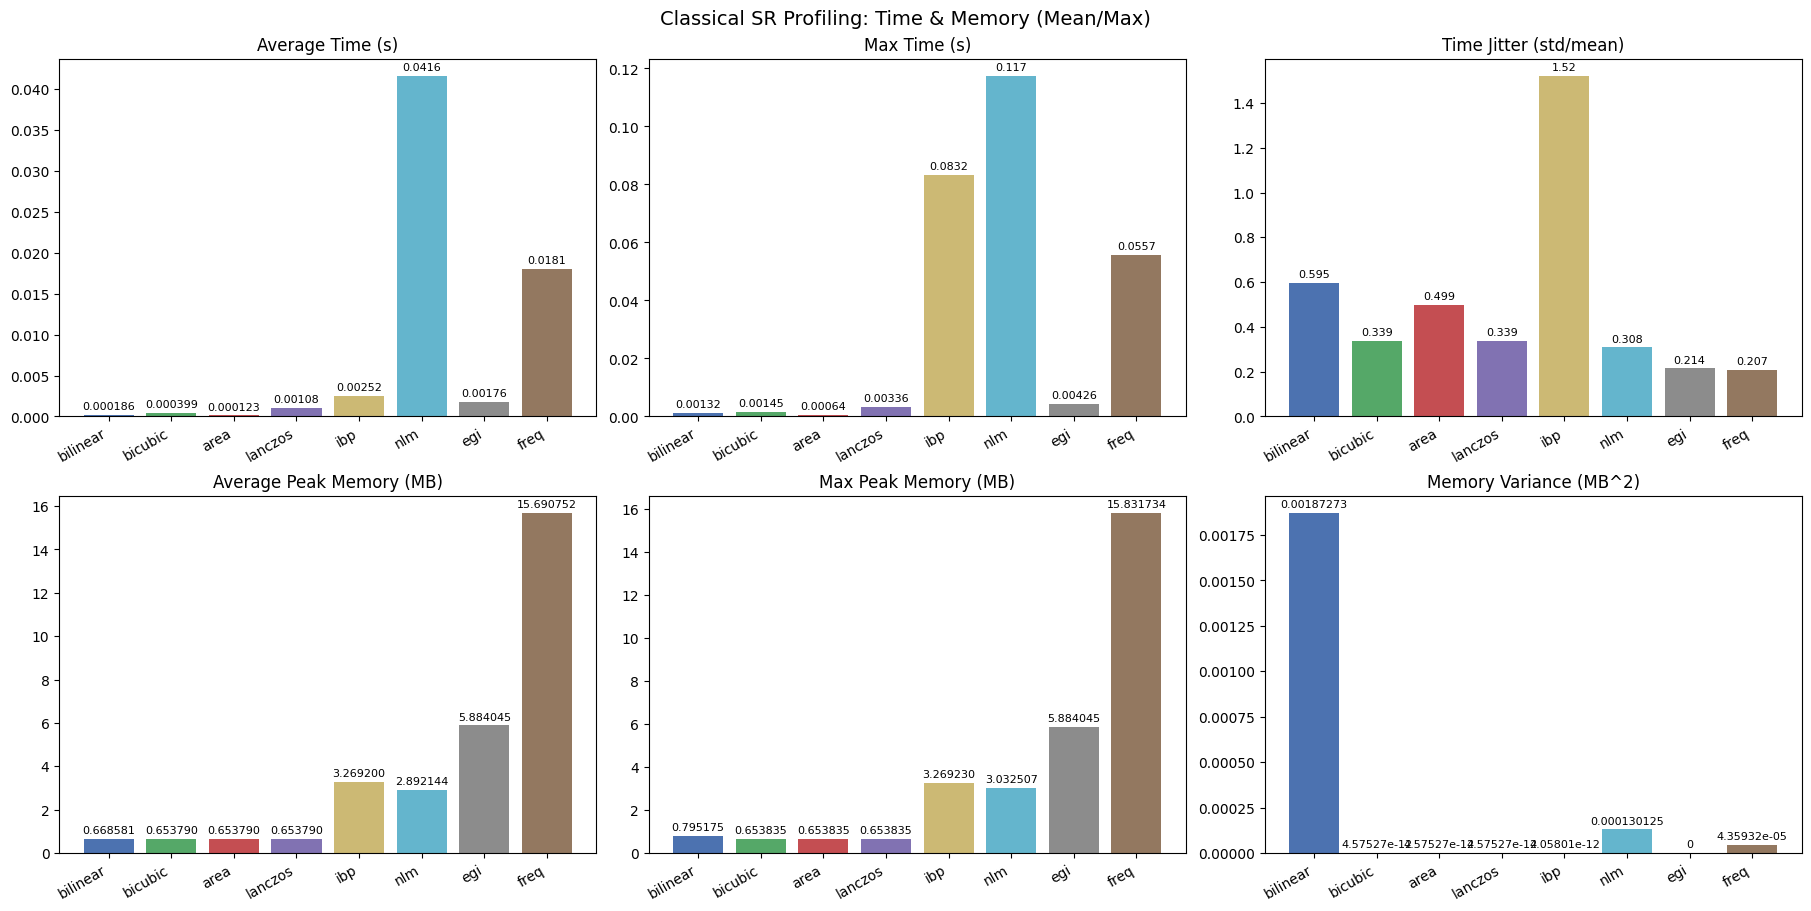

In [6]:
plot_time_memory_panels(
    metric_summary=metric_summary,
    algorithms_order=algorithms,
    colors_map=colors,
    main_title='Classical SR Profiling: Time & Memory (Mean/Max)',
    outfile=RESULTS_DIR / 'time_memory_summary.png',
    figsize=(18, 9)
)

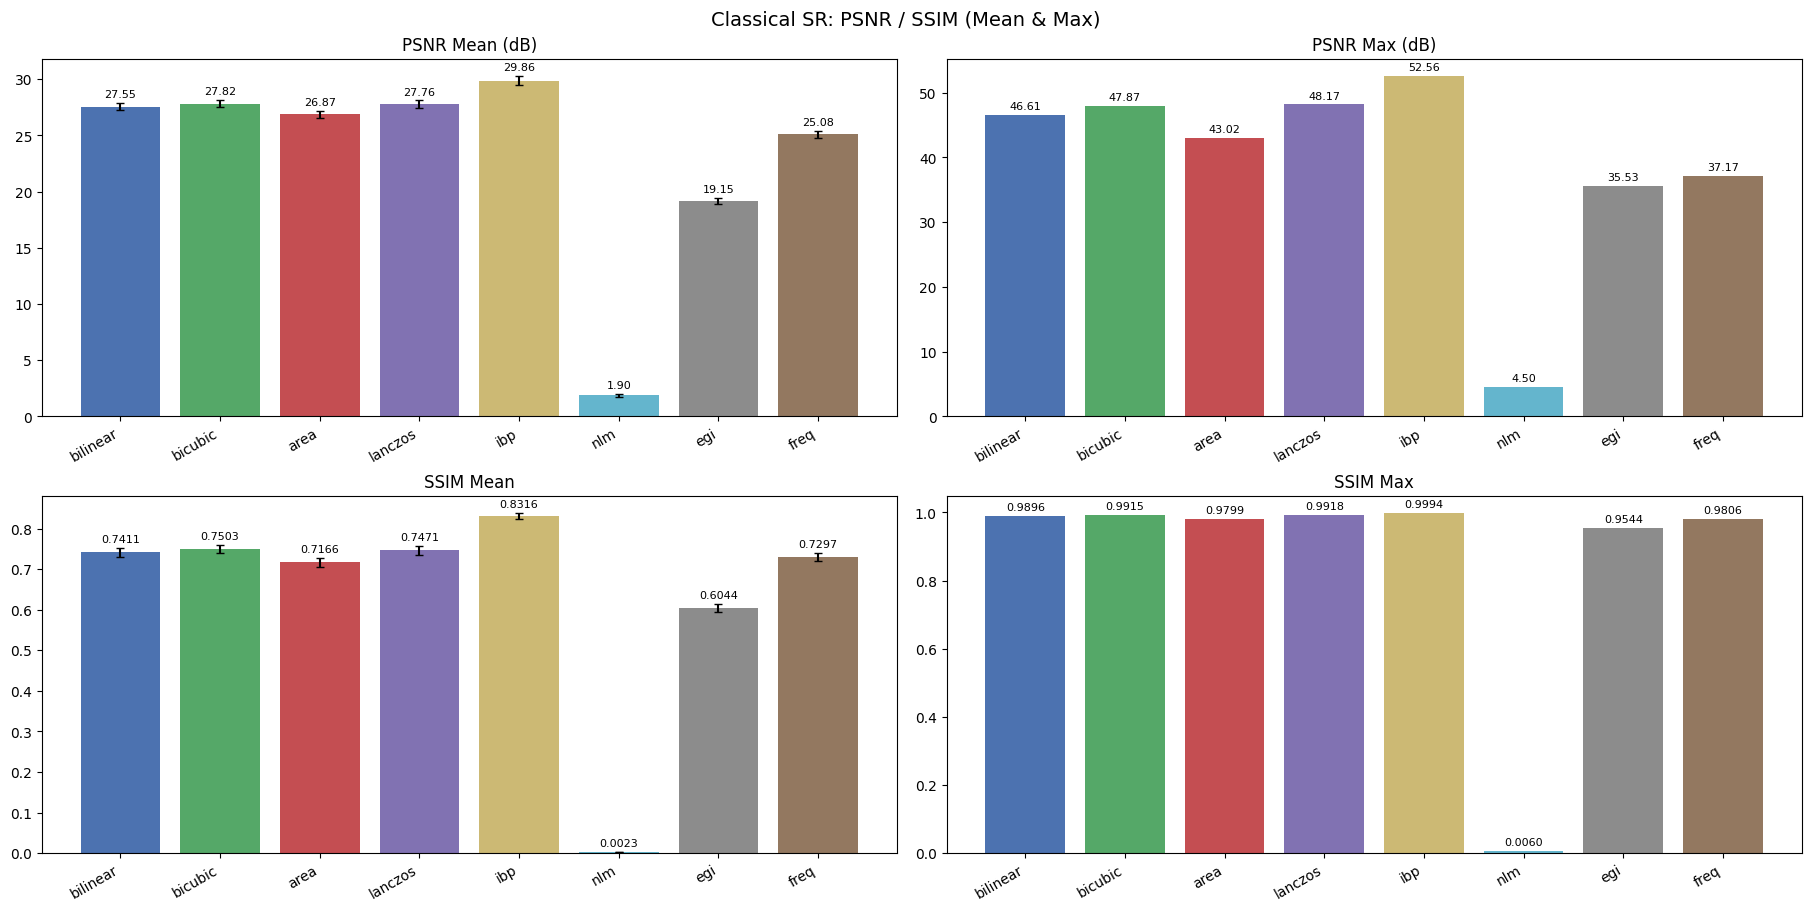

In [7]:
plot_psnr_ssim_panels(
    metric_summary=metric_summary,
    algorithms_order=algorithms,
    colors_map=colors,
    main_title='Classical SR: PSNR / SSIM (Mean & Max)',
    outfile=RESULTS_DIR / 'psnr_ssim_summary.png',
    figsize=(18, 9)
)

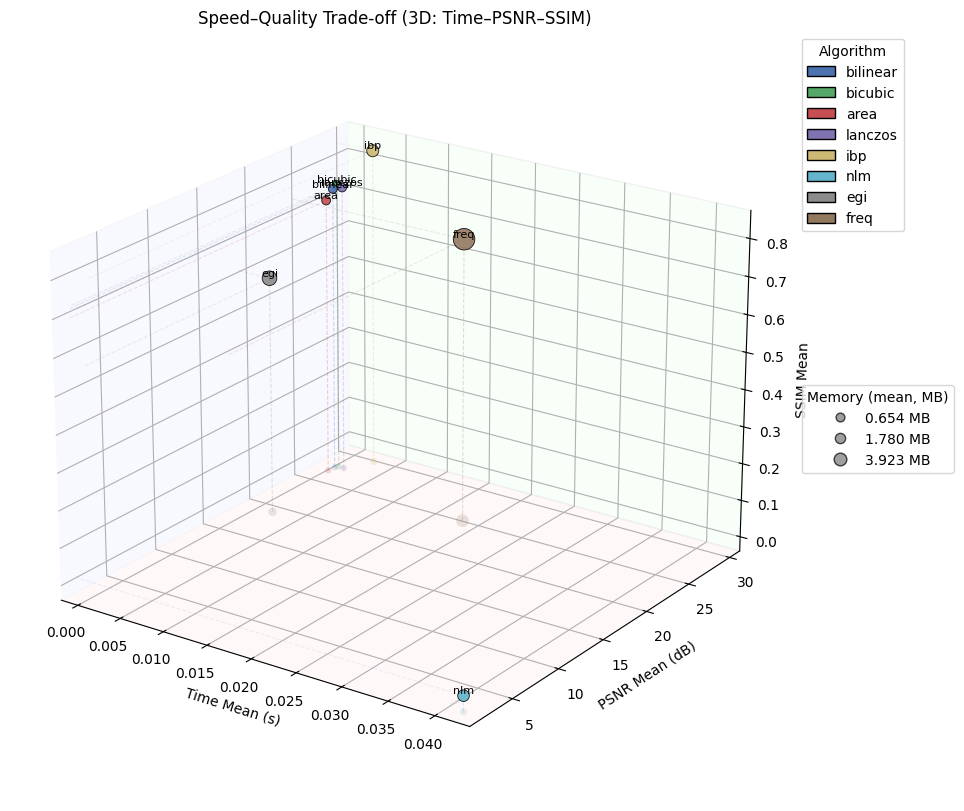

In [8]:
plot_speed_quality_tradeoff_3d(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    save=True,
    figsize=(10, 8),
    view=(22, -55),
)

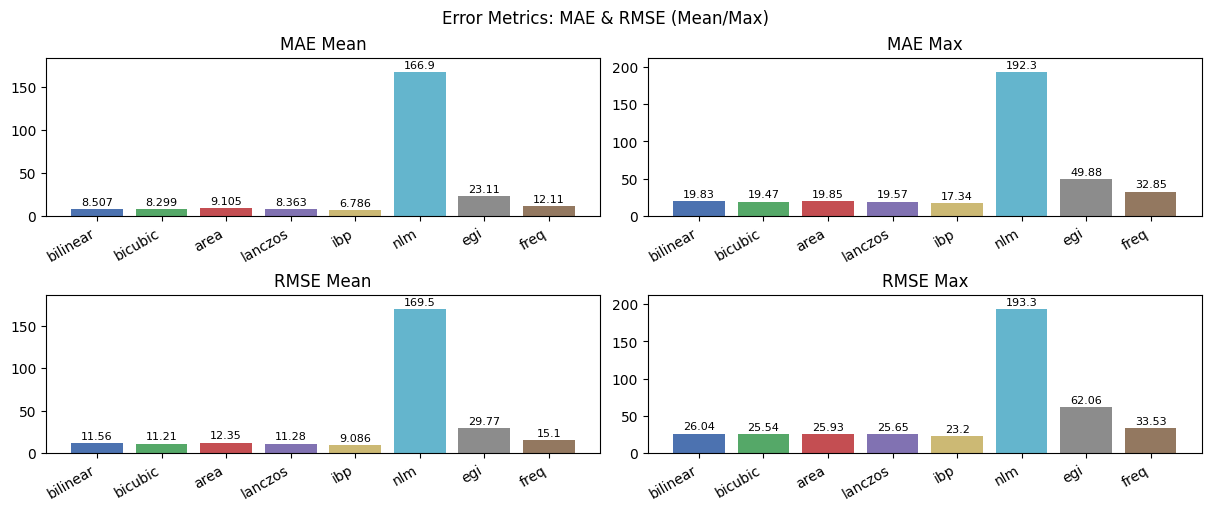

In [9]:
plot_error_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(12, 5),
)

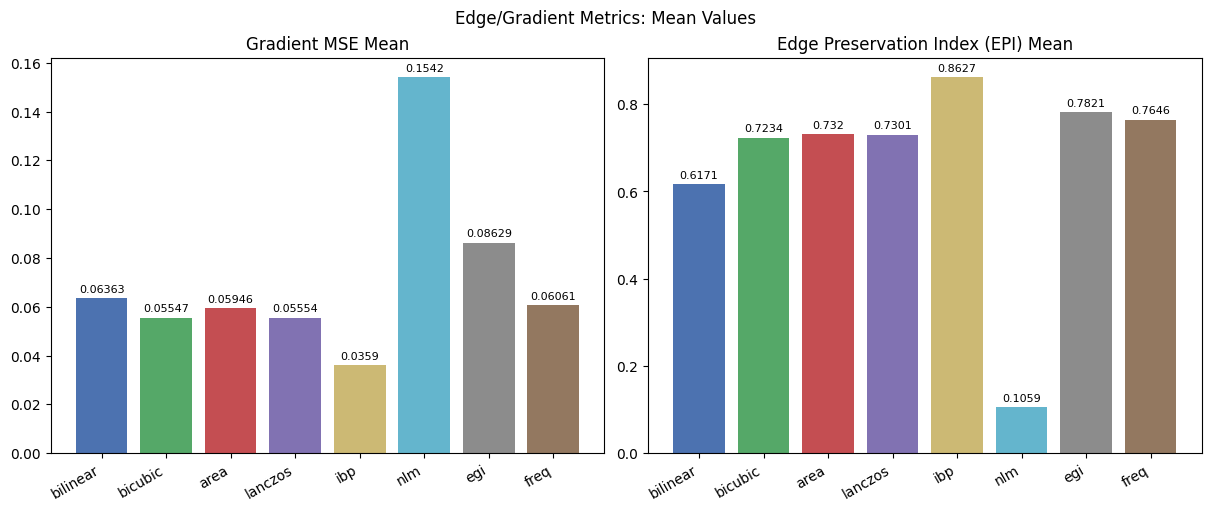

In [10]:
plot_edge_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(12, 5)
)

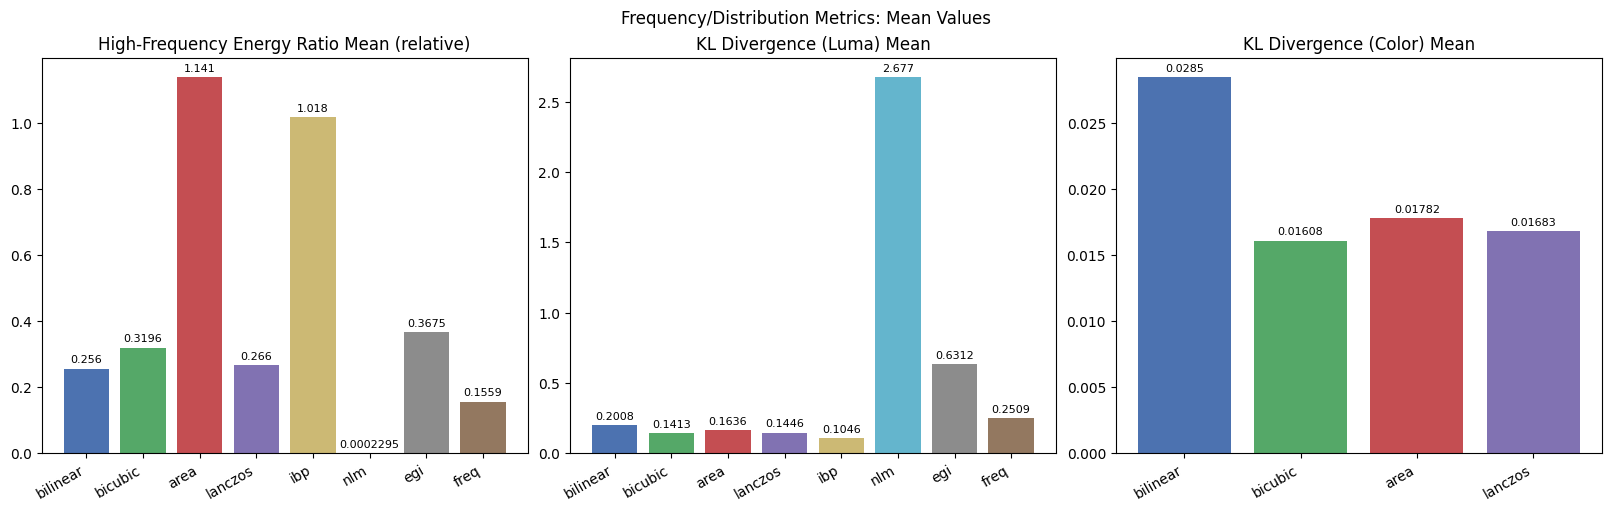

In [11]:
plot_frequency_distribution_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(16, 5)
)

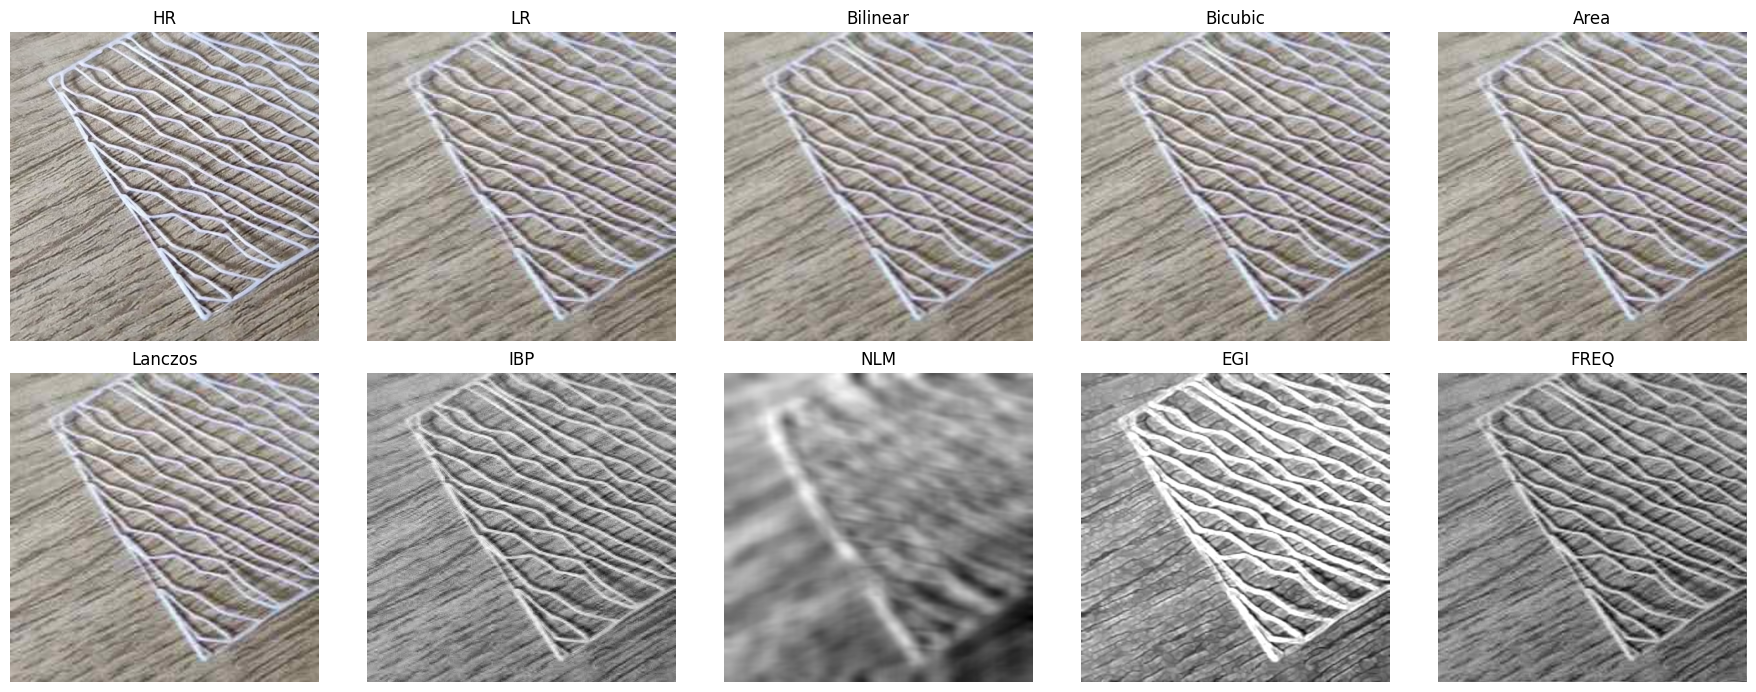

In [12]:
plot_and_save_super_resolution_example(vis, ibp_example, nlm_example, egi_example, freq_example, RESULTS_DIR)

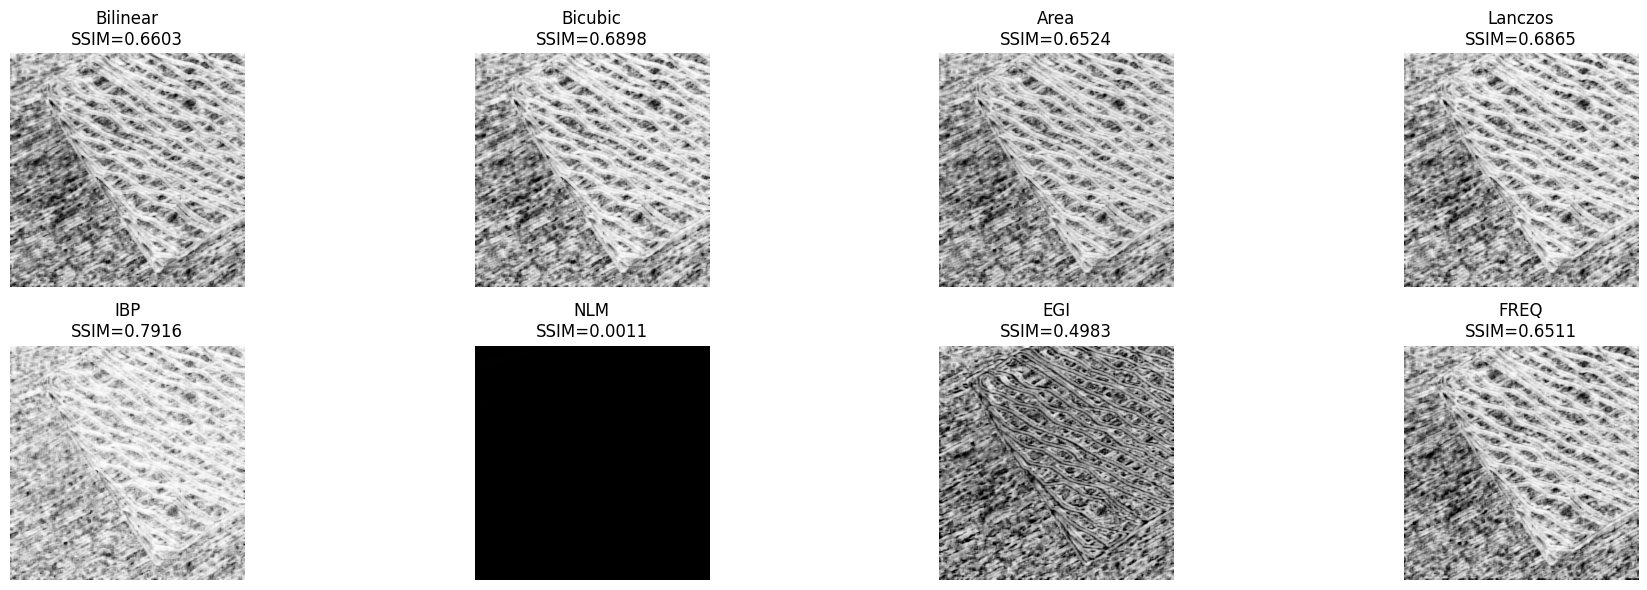

In [13]:
plot_and_save_ssim_similarity_maps(vis, ibp_example, nlm_example, egi_example, freq_example, RESULTS_DIR)

Ranking (best to worst):
 1. bicubic     score=0.9461
 2. lanczos     score=0.9391
 3. ibp         score=0.9239
 4. area        score=0.9188
 5. bilinear    score=0.8869
 6. egi         score=0.7020
 7. freq        score=0.6948
 8. nlm         score=0.0851


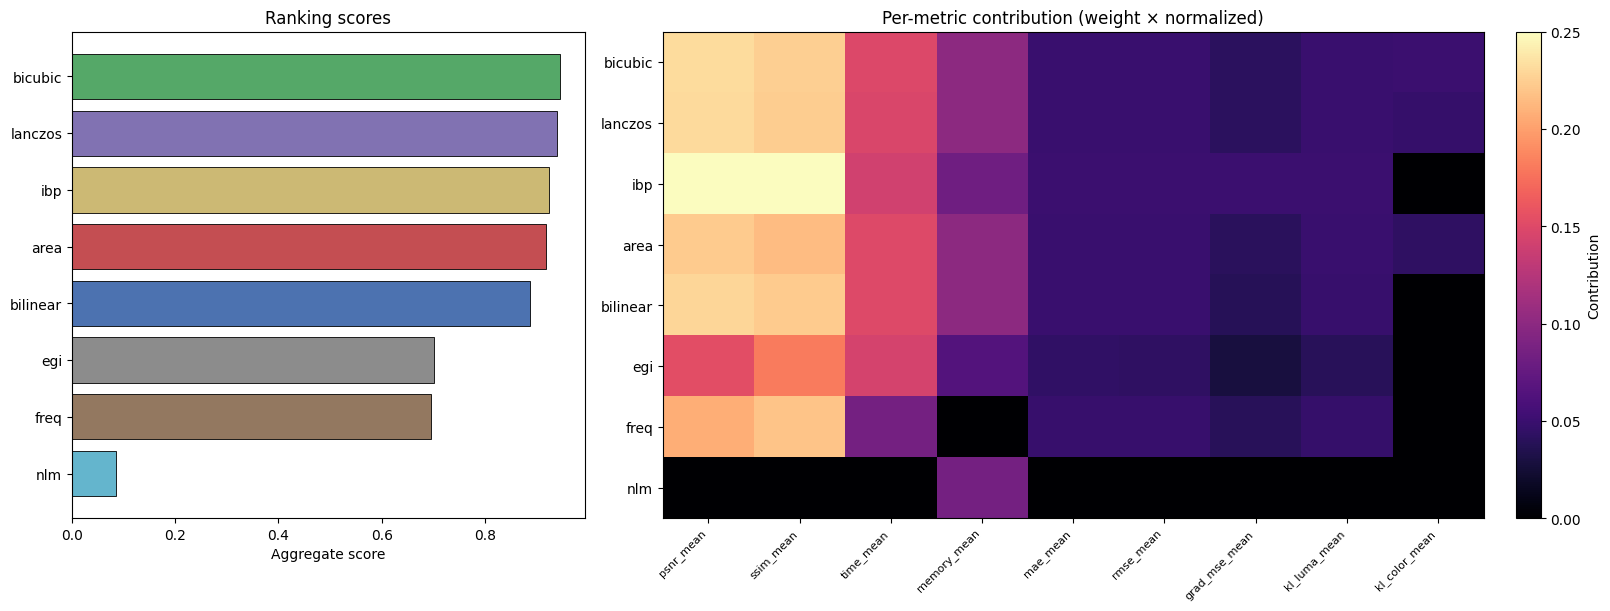

([('bicubic', 0.9461053989921107),
  ('lanczos', 0.9390502572569838),
  ('ibp', 0.9239497937828154),
  ('area', 0.9187501546186551),
  ('bilinear', 0.8868634592213547),
  ('egi', 0.7019787392636255),
  ('freq', 0.6947841308850846),
  ('nlm', 0.08511431714423304)],
 {'bilinear': 0.8868634592213547,
  'bicubic': 0.9461053989921107,
  'area': 0.9187501546186551,
  'lanczos': 0.9390502572569838,
  'ibp': 0.9239497937828154,
  'nlm': 0.08511431714423304,
  'egi': 0.7019787392636255,
  'freq': 0.6947841308850846},
 {'psnr_mean': (1.8972120082724464, 29.85940665172775),
  'ssim_mean': (0.0022956149891707823, 0.8316419339941709),
  'time_mean': (0.00012296069864660002, 0.041591073144040445),
  'memory_mean': (685548.1048034935, 16452946.364628822),
  'mae_mean': (6.785856557269804, 166.89217949746478),
  'rmse_mean': (9.085760426341201, 169.5012130050878),
  'grad_mse_mean': (0.03590304862559983, 0.15422873588176708),
  'kl_luma_mean': (0.10463706560167553, 2.677294924024404),
  'kl_color_mean

In [14]:
show_algorithm_ranking(
    metric_summary=metric_summary,
    maximize=['psnr_mean', 'ssim_mean'],
    minimize=['time_mean', 'memory_mean', 'mae_mean', 'rmse_mean', 'grad_mse_mean', 'kl_luma_mean', 'kl_color_mean'],
    weights={
        'psnr_mean': 0.25,
        'ssim_mean': 0.25,
        'time_mean': 0.15,
        'memory_mean': 0.10,
        'mae_mean': 0.05,
        'rmse_mean': 0.05,
        'grad_mse_mean': 0.05,
        'kl_luma_mean': 0.05,
        'kl_color_mean': 0.05,
    },
    results_dir=RESULTS_DIR, 
    filename='algorithm_ranking.png',
    dpi=150, 
    colors_map=colors
)